In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_selection import SelectFromModel
from nltk.stem import PorterStemmer


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\iKhan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
try:
    df = pd.read_csv("Abstracts_TP_TN.csv")#, sep=",")
    print(" dataset has {} samples with {} features each.".format(*df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

 dataset has 284 samples with 2 features each.


In [3]:
#df.head()

In [4]:
df.columns

Index(['pubmed_id;abstract;class;', 'Unnamed: 1'], dtype='object')

In [5]:
df_tidy = df.rename(columns = {'pubmed_id;abstract;class;': 'col1', 'Unnamed: 1': 'col2'}, inplace = False)
#df_tidy.head()
df_temp = df_tidy.col1.str.split(";",expand=True) 
df_temp.head()

,0,1,2,3
0,26561364,"Andrographolide, the major labdane diterpenoid...",-1,
1,26561979,DGAT2 plays a critical role in hepatic triglyc...,-1,
2,26562217,Despite the success of imatinib at inhibiting ...,-1,
3,26565745,Two benzazaborinine analogues of propranolol w...,-1,
4,26572282,Our recent study has shown that the natural pr...,-1,


In [6]:
df_temp.columns

RangeIndex(start=0, stop=4, step=1)

In [7]:
df_ready = df_temp.rename(columns = {0: 'pubmed_id', 1: 'abstract', 2: 'target_ML_model', 3: 'dlt'}, inplace = False)
df_ready.head()

,pubmed_id,abstract,target_ML_model,dlt
0,26561364,"Andrographolide, the major labdane diterpenoid...",-1,
1,26561979,DGAT2 plays a critical role in hepatic triglyc...,-1,
2,26562217,Despite the success of imatinib at inhibiting ...,-1,
3,26565745,Two benzazaborinine analogues of propranolol w...,-1,
4,26572282,Our recent study has shown that the natural pr...,-1,


In [8]:
del df_ready['dlt']

In [9]:
df_ready = df_ready.drop(df_ready[df_ready['target_ML_model'] == '1'].sample(frac=0.98).index)


In [10]:
df_ready.head()

,pubmed_id,abstract,target_ML_model
0,26561364,"Andrographolide, the major labdane diterpenoid...",-1
1,26561979,DGAT2 plays a critical role in hepatic triglyc...,-1
2,26562217,Despite the success of imatinib at inhibiting ...,-1
3,26565745,Two benzazaborinine analogues of propranolol w...,-1
4,26572282,Our recent study has shown that the natural pr...,-1


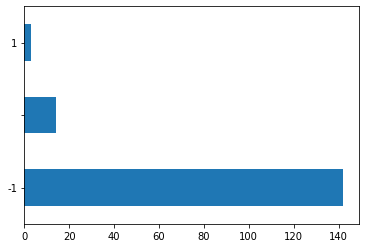

In [11]:
df_ready['target_ML_model'].value_counts().plot(kind='barh')

In [12]:
df_ready['target_ML_model'].value_counts()

-1    142
       14
1       3
Name: target_ML_model, dtype: int64

In [13]:
print(df_ready.dtypes)

pubmed_id          object
abstract           object
target_ML_model    object
dtype: object


In [14]:
df_ready['abstract'] = df_ready['abstract'].str.lower()

In [15]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())

df_ready['word_count'] = df_ready.abstract.apply(word_count)

In [16]:
#data = list(df_ready.abstract)
from gensim.utils import simple_preprocess
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['can', 'do', 'the', 'be', 'will', 'Find', 'third', 'also', 'use', 'etc' ])
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iKhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when',

In [17]:
def remove_stopwords(texts):
    #return [[word for word in text if word not in stop_words] for doc in texts]
    return [[word for word in simple_preprocess(str(doc), deacc=True) if word not in stop_words] for doc in texts]


df_ready['data_words_nostops'] = remove_stopwords(df_ready.abstract)
df_ready.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,..."
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc..."
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ..."
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,..."
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch..."


In [18]:
df_ready['data_words_nostops_Joined'] = df_ready.data_words_nostops.apply(','.join)

In [19]:
df_ready.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops,data_words_nostops_Joined
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,...","andrographolide,major,labdane,diterpenoid,andr..."
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc...","dgat,plays,critical,role,hepatic,triglyceride,..."
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ...","despite,success,imatinib,inhibiting,bcr,abl,tr..."
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,...","two,benzazaborinine,analogues,propranolol,synt..."
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch...","recent,study,shown,natural,product,bouchardati..."


In [20]:
data_words_nostops = remove_stopwords(df_ready.abstract)

In [21]:
from nltk.stem.snowball import SnowballStemmer

# Use English stemmer.
stemmer = SnowballStemmer("english")

df_ready['stemmed'] = df_ready['data_words_nostops'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
#df_ready.head()

In [22]:
df_ready['stemmed_Joined'] = df_ready.stemmed.apply(','.join)
df_ready.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops,data_words_nostops_Joined,stemmed,stemmed_Joined
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,...","andrographolide,major,labdane,diterpenoid,andr...","[andrographolid, major, labdan, diterpenoid, a...","andrographolid,major,labdan,diterpenoid,androg..."
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc...","dgat,plays,critical,role,hepatic,triglyceride,...","[dgat, play, critic, role, hepat, triglycerid,...","dgat,play,critic,role,hepat,triglycerid,produc..."
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ...","despite,success,imatinib,inhibiting,bcr,abl,tr...","[despit, success, imatinib, inhibit, bcr, abl,...","despit,success,imatinib,inhibit,bcr,abl,treat,..."
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,...","two,benzazaborinine,analogues,propranolol,synt...","[two, benzazaborinin, analogu, propranolol, sy...","two,benzazaborinin,analogu,propranolol,synthes..."
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch...","recent,study,shown,natural,product,bouchardati...","[recent, studi, shown, natur, product, bouchar...","recent,studi,shown,natur,product,bouchardatin,..."


In [23]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_ready['text_lemmatized'] = df_ready.stemmed_Joined.apply(lemmatize_text)
df_ready.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops,data_words_nostops_Joined,stemmed,stemmed_Joined,text_lemmatized
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,...","andrographolide,major,labdane,diterpenoid,andr...","[andrographolid, major, labdan, diterpenoid, a...","andrographolid,major,labdan,diterpenoid,androg...","[andrographolid,major,labdan,diterpenoid,andro..."
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc...","dgat,plays,critical,role,hepatic,triglyceride,...","[dgat, play, critic, role, hepat, triglycerid,...","dgat,play,critic,role,hepat,triglycerid,produc...","[dgat,play,critic,role,hepat,triglycerid,produ..."
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ...","despite,success,imatinib,inhibiting,bcr,abl,tr...","[despit, success, imatinib, inhibit, bcr, abl,...","despit,success,imatinib,inhibit,bcr,abl,treat,...","[despit,success,imatinib,inhibit,bcr,abl,treat..."
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,...","two,benzazaborinine,analogues,propranolol,synt...","[two, benzazaborinin, analogu, propranolol, sy...","two,benzazaborinin,analogu,propranolol,synthes...","[two,benzazaborinin,analogu,propranolol,synthe..."
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch...","recent,study,shown,natural,product,bouchardati...","[recent, studi, shown, natur, product, bouchar...","recent,studi,shown,natur,product,bouchardatin,...","[recent,studi,shown,natur,product,bouchardatin..."


In [24]:
df_ready['text_lemmatized_Joined'] = df_ready.text_lemmatized.apply(','.join)

In [25]:
df_ready['bigrams'] = df_ready['text_lemmatized_Joined'].apply(lambda row: list(nltk.bigrams(row.split(','))))
#df_ready['bigrams'] = df_ready['text_lemmatized'].apply(lambda row: list(nltk.bigrams(row.split(','))))
#df_ready['trigrams'] = df_ready['data_words_nostops_Joined'].apply(lambda row: list(nltk.trigrams(row.split(' '))))

In [26]:
df_ready.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops,data_words_nostops_Joined,stemmed,stemmed_Joined,text_lemmatized,text_lemmatized_Joined,bigrams
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,...","andrographolide,major,labdane,diterpenoid,andr...","[andrographolid, major, labdan, diterpenoid, a...","andrographolid,major,labdan,diterpenoid,androg...","[andrographolid,major,labdan,diterpenoid,andro...","andrographolid,major,labdan,diterpenoid,androg...","[(andrographolid, major), (major, labdan), (la..."
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc...","dgat,plays,critical,role,hepatic,triglyceride,...","[dgat, play, critic, role, hepat, triglycerid,...","dgat,play,critic,role,hepat,triglycerid,produc...","[dgat,play,critic,role,hepat,triglycerid,produ...","dgat,play,critic,role,hepat,triglycerid,produc...","[(dgat, play), (play, critic), (critic, role),..."
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ...","despite,success,imatinib,inhibiting,bcr,abl,tr...","[despit, success, imatinib, inhibit, bcr, abl,...","despit,success,imatinib,inhibit,bcr,abl,treat,...","[despit,success,imatinib,inhibit,bcr,abl,treat...","despit,success,imatinib,inhibit,bcr,abl,treat,...","[(despit, success), (success, imatinib), (imat..."
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,...","two,benzazaborinine,analogues,propranolol,synt...","[two, benzazaborinin, analogu, propranolol, sy...","two,benzazaborinin,analogu,propranolol,synthes...","[two,benzazaborinin,analogu,propranolol,synthe...","two,benzazaborinin,analogu,propranolol,synthes...","[(two, benzazaborinin), (benzazaborinin, analo..."
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch...","recent,study,shown,natural,product,bouchardati...","[recent, studi, shown, natur, product, bouchar...","recent,studi,shown,natur,product,bouchardatin,...","[recent,studi,shown,natur,product,bouchardatin...","recent,studi,shown,natur,product,bouchardatin,...","[(recent, studi), (studi, shown), (shown, natu..."


In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_ready = df_ready.join(pd.DataFrame(mlb.fit_transform(df_ready.pop('bigrams')),
                          columns=mlb.classes_,
                          index=df_ready.index))

In [28]:
df_ready.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops,data_words_nostops_Joined,stemmed,stemmed_Joined,text_lemmatized,text_lemmatized_Joined,...,"(ylmethylen, hex)","(zinc, chelat)","(zinc, finger)","(zip, code)","(zone, express)","(zone, misexpress)","(zwitterion, guanidium)","(zygot, contribut)","(zygot, express)","(zygot, rna)"
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,...","andrographolide,major,labdane,diterpenoid,andr...","[andrographolid, major, labdan, diterpenoid, a...","andrographolid,major,labdan,diterpenoid,androg...","[andrographolid,major,labdan,diterpenoid,andro...","andrographolid,major,labdan,diterpenoid,androg...",...,0,0,0,0,0,0,0,0,0,0
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc...","dgat,plays,critical,role,hepatic,triglyceride,...","[dgat, play, critic, role, hepat, triglycerid,...","dgat,play,critic,role,hepat,triglycerid,produc...","[dgat,play,critic,role,hepat,triglycerid,produ...","dgat,play,critic,role,hepat,triglycerid,produc...",...,0,0,0,0,0,0,0,0,0,0
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ...","despite,success,imatinib,inhibiting,bcr,abl,tr...","[despit, success, imatinib, inhibit, bcr, abl,...","despit,success,imatinib,inhibit,bcr,abl,treat,...","[despit,success,imatinib,inhibit,bcr,abl,treat...","despit,success,imatinib,inhibit,bcr,abl,treat,...",...,0,0,0,0,0,0,0,0,0,0
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,...","two,benzazaborinine,analogues,propranolol,synt...","[two, benzazaborinin, analogu, propranolol, sy...","two,benzazaborinin,analogu,propranolol,synthes...","[two,benzazaborinin,analogu,propranolol,synthe...","two,benzazaborinin,analogu,propranolol,synthes...",...,0,0,0,0,0,0,0,0,0,0
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch...","recent,study,shown,natural,product,bouchardati...","[recent, studi, shown, natur, product, bouchar...","recent,studi,shown,natur,product,bouchardatin,...","[recent,studi,shown,natur,product,bouchardatin...","recent,studi,shown,natur,product,bouchardatin,...",...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_ready.shape

(159, 9913)

In [30]:
#df_ready['data_words_nostops_Joined'].apply(pd.Series)
mono_data = df_ready.text_lemmatized.apply(','.join).str.get_dummies(sep=',')
mono_data.columns

Index(['aaic', 'ab', 'abietan', 'abil', 'abl', 'abnorm', 'absenc', 'absolut',
       'abus', 'ac',
       ...
       'yeast', 'yet', 'yield', 'yl', 'ylmethylen', 'zinc', 'zip', 'zone',
       'zwitterion', 'zygot'],
      dtype='object', length=2766)

In [31]:
#full_data.shape

In [32]:
full_data = pd.concat([df_ready, mono_data], axis=1, sort=False)
full_data.shape

(159, 12679)

In [33]:
full_data.columns

Index([                'pubmed_id',                  'abstract',
                 'target_ML_model',                'word_count',
              'data_words_nostops', 'data_words_nostops_Joined',
                         'stemmed',            'stemmed_Joined',
                 'text_lemmatized',    'text_lemmatized_Joined',
       ...
                           'yeast',                       'yet',
                           'yield',                        'yl',
                      'ylmethylen',                      'zinc',
                             'zip',                      'zone',
                      'zwitterion',                     'zygot'],
      dtype='object', length=12679)

In [34]:
#mono_data[mono_data.columns[pd.Series(mono_data.columns).str.startswith('abstract')]]


In [35]:
full_data['class'].dtypes

dtype('int64')

In [36]:
full_data.head()

,pubmed_id,abstract,target_ML_model,word_count,data_words_nostops,data_words_nostops_Joined,stemmed,stemmed_Joined,text_lemmatized,text_lemmatized_Joined,...,yeast,yet,yield,yl,ylmethylen,zinc,zip,zone,zwitterion,zygot
0,26561364,"andrographolide, the major labdane diterpenoid...",-1,136,"[andrographolide, major, labdane, diterpenoid,...","andrographolide,major,labdane,diterpenoid,andr...","[andrographolid, major, labdan, diterpenoid, a...","andrographolid,major,labdan,diterpenoid,androg...","[andrographolid,major,labdan,diterpenoid,andro...","andrographolid,major,labdan,diterpenoid,androg...",...,0,0,0,0,0,0,0,0,0,0
1,26561979,dgat2 plays a critical role in hepatic triglyc...,-1,57,"[dgat, plays, critical, role, hepatic, triglyc...","dgat,plays,critical,role,hepatic,triglyceride,...","[dgat, play, critic, role, hepat, triglycerid,...","dgat,play,critic,role,hepat,triglycerid,produc...","[dgat,play,critic,role,hepat,triglycerid,produ...","dgat,play,critic,role,hepat,triglycerid,produc...",...,0,0,0,0,0,0,0,0,0,0
2,26562217,despite the success of imatinib at inhibiting ...,-1,149,"[despite, success, imatinib, inhibiting, bcr, ...","despite,success,imatinib,inhibiting,bcr,abl,tr...","[despit, success, imatinib, inhibit, bcr, abl,...","despit,success,imatinib,inhibit,bcr,abl,treat,...","[despit,success,imatinib,inhibit,bcr,abl,treat...","despit,success,imatinib,inhibit,bcr,abl,treat,...",...,0,0,0,0,0,0,0,0,0,0
3,26565745,two benzazaborinine analogues of propranolol w...,-1,66,"[two, benzazaborinine, analogues, propranolol,...","two,benzazaborinine,analogues,propranolol,synt...","[two, benzazaborinin, analogu, propranolol, sy...","two,benzazaborinin,analogu,propranolol,synthes...","[two,benzazaborinin,analogu,propranolol,synthe...","two,benzazaborinin,analogu,propranolol,synthes...",...,0,0,0,0,0,0,0,0,0,0
4,26572282,our recent study has shown that the natural pr...,-1,149,"[recent, study, shown, natural, product, bouch...","recent,study,shown,natural,product,bouchardati...","[recent, studi, shown, natur, product, bouchar...","recent,studi,shown,natur,product,bouchardatin,...","[recent,studi,shown,natur,product,bouchardatin...","recent,studi,shown,natur,product,bouchardatin,...",...,0,0,0,0,0,0,0,0,0,0


In [37]:
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#x = df_ready.values#sentences = df_ready['data_lemmatized_bigrams_Joined'].values
#X = df_ready.values#sentences = df_ready['data_lemmatized_bigrams_Joined'].values
#full_data  = full_data.set_index('pubmed_id')
#X = df_ready.loc[:, df_ready.columns != ['abstract', 'word_count', 'data_words_nostops', 'data_words_nostops_Joined']]

X = full_data.drop(['abstract', 'word_count', 'data_words_nostops', 'data_words_nostops_Joined','text_lemmatized', 'text_lemmatized_Joined','target_ML_model', 'stemmed', 'stemmed_Joined'], axis=1)
#full_data['target_ML_model'] = full_data['target_ML_model'].astype(float)

y = full_data['target_ML_model'].values

In [38]:
X.head()

,pubmed_id,"(aaic, herein)","(ab, cultur)","(abietan, diterpenoid)","(abietan, skeleton)","(abil, alter)","(abil, form)","(abil, hexahydro)","(abil, induc)","(abil, inhibit)",...,yeast,yet,yield,yl,ylmethylen,zinc,zip,zone,zwitterion,zygot
0,26561364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26561979,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26562217,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26565745,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26572282,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#X.get_dtype_counts() 
X  = X.set_index('pubmed_id')

In [40]:
x_train, x_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=1000)
#y = df_ready['class'].values
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(119, 12669)
(40, 12669)
(119,)
(40,)


In [41]:
x_train.dtypes

(aaic, herein)            int32
(ab, cultur)              int32
(abietan, diterpenoid)    int32
(abietan, skeleton)       int32
(abil, alter)             int32
                          ...  
zinc                      int64
zip                       int64
zone                      int64
zwitterion                int64
zygot                     int64
Length: 12669, dtype: object

In [42]:
C = [10, 1, .1, .001, .0001]

for c in C:
    sel_ = SelectFromModel(LogisticRegression(C=c, penalty='l2'))
    sel_.fit(x_train, y_train)
    selected_features = sel_.get_support()
    np.sum(selected_features)
    selected_feat = x_train.columns[(sel_.get_support())]
    print('total features: {}'.format((x_train.shape[1])))
    print('selected features: {}'.format(len(selected_feat)))
    print('features with coefficients shrank to zero: {}'.format(
          np.sum(sel_.estimator_.coef_ == 0)))

C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


total features: 12669
selected features: 3877
features with coefficients shrank to zero: 8409
total features: 12669
selected features: 3895
features with coefficients shrank to zero: 8409
total features: 12669
selected features: 4012
features with coefficients shrank to zero: 8409


C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


total features: 12669
selected features: 2482
features with coefficients shrank to zero: 8409
total features: 12669
selected features: 1358
features with coefficients shrank to zero: 8409


C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [43]:
"""
sel_ = SelectFromModel(LogisticRegression(C=0.0001, penalty='l2'))
sel_.fit(x_train, y_train)
selected_features = sel_.get_support()
np.sum(selected_features)

selected_feat = x_train.columns[(sel_.get_support())]
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    clf.fit(x_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(x_train, y_train))
    print('Test accuracy:', clf.score(x_test, y_test))
    print(classification_report(y_test, clf.predict(x_test)))
    #sel_ = SelectFromModel(LogisticRegression(C=c, penalty='l1'))
    #sel_.get_support()
    print('')"""

"\nsel_ = SelectFromModel(LogisticRegression(C=0.0001, penalty='l2'))\nsel_.fit(x_train, y_train)\nselected_features = sel_.get_support()\nnp.sum(selected_features)\n\nselected_feat = x_train.columns[(sel_.get_support())]\nprint('total features: {}'.format((x_train.shape[1])))\nprint('selected features: {}'.format(len(selected_feat)))\nprint('features with coefficients shrank to zero: {}'.format(\n      np.sum(sel_.estimator_.coef_ == 0)))\n\nC = [10, 1, .1, .001]\n\nfor c in C:\n    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear')\n    clf.fit(x_train, y_train)\n    print('C:', c)\n    print('Coefficient of each feature:', clf.coef_)\n    print('Training accuracy:', clf.score(x_train, y_train))\n    print('Test accuracy:', clf.score(x_test, y_test))\n    print(classification_report(y_test, clf.predict(x_test)))\n    #sel_ = SelectFromModel(LogisticRegression(C=c, penalty='l1'))\n    #sel_.get_support()\n    print('')"

In [44]:
#(model.predict_proba(x_test)[:,1] > threshold).astype(int)

In [45]:
clf = LogisticRegression(penalty='l2', C=.0001, solver='liblinear')
clf.fit(x_train[selected_feat], y_train)
print('C:', c)
print('Coefficient of each feature:', clf.coef_)
print('Training accuracy:', clf.score(x_train[selected_feat], y_train))
print('Test accuracy:', clf.score(x_test[selected_feat], y_test))
print(classification_report(y_test, clf.predict(x_test[selected_feat])))

C: 0.0001
Coefficient of each feature: [[-9.75196861e-05 -4.41332754e-04 -9.82474291e-05 ...  1.01033810e-04
  -3.43355446e-04 -3.42770178e-04]
 [ 9.75803472e-05  4.41611272e-04  9.83384352e-05 ... -1.00942522e-04
   3.43533053e-04  3.42984682e-04]
 [-9.73913202e-05 -4.40868828e-04 -9.81005363e-05 ... -9.85217820e-05
  -3.42936454e-04 -3.42337390e-04]]
Training accuracy: 0.8991596638655462
Test accuracy: 0.875
              precision    recall  f1-score   support

                   0.00      0.00      0.00         4
          -1       0.88      1.00      0.93        35
           1       0.00      0.00      0.00         1

   micro avg       0.88      0.88      0.88        40
   macro avg       0.29      0.33      0.31        40
weighted avg       0.77      0.88      0.82        40



C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\iKhan\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
#f = open('names.txt', 'w')

for col in x_train[selected_feat].columns: 
    print(col) 
  #  f.write(col + '\n')

('abil', 'inhibit')
('absolut', 'configur')
('acid', 'residu')
('activ', 'among')
('activ', 'analogu')
('activ', 'compar')
('activ', 'compound')
('activ', 'demonstr')
('activ', 'ic')
('activ', 'mda')
('activ', 'mycobacterium')
('activ', 'panel')
('activ', 'possibl')
('activ', 'relationship')
('activ', 'screen')
('activ', 'sever')
('activ', 'site')
('activ', 'test')
('activ', 'toward')
('activ', 'use')
('activ', 'well')
('addit', 'display')
('adp', 'ribos')
('age', 'relat')
('agonist', 'activ')
('alloster', 'modul')
('allow', 'identif')
('almost', 'cell')
('alzheim', 'diseas')
('amid', 'deriv')
('amino', 'acid')
('among', 'compound')
('among', 'test')
('amyloid', 'aggreg')
('analogu', 'evalu')
('analogu', 'exhibit')
('analogu', 'prepar')
('analogu', 'synthes')
('analysi', 'nmr')
('anti', 'cancer')
('anti', 'inflammatori')
('anti', 'prolif')
('antibacteri', 'activ')
('antibacteri', 'antifung')
('anticanc', 'activ')
('anticanc', 'agent')
('anticonvuls', 'activ')
('antifung', 'activ')
('an

protocol
prove
provid
ptp
purifi
pyridin
quaternari
quinazolin
quinolin
radic
rang
rapid
rare
rat
rate
ration
ray
reaction
recent
receptor
recombin
recruit
reduc
reduct
reductas
refer
regard
region
regul
regulatori
relat
relationship
releas
relev
remain
remark
replac
replic
report
repres
research
residu
resist
respect
respons
result
resveratrol
reveal
revis
ribos
rich
ring
rna
robust
role
rout
safeti
sar
satur
scaffold
screen
sea
search
secondari
seizur
select
sensit
sequenc
sequenti
seri
serv
set
seven
sever
sgf
sh
show
shown
side
sif
signal
signific
silico
similar
simul
sinc
singl
site
six
size
skeleton
slight
small
solid
solubl
sp
spare
speci
specif
spectra
spectroscop
spectrum
stabil
stabl
staphylococcus
start
state
stem
step
steric
steroid
stilben
stimul
strain
strand
strategi
streptomyc
strong
structur
studi
sub
subject
submicromolar
subsequ
substanti
substitut
substrat
success
suggest
suitabl
superior
support
suppress
surfac
surrog
synthas
synthes
synthesi
synthet
system
systema